# Traveltime tomography exercise
This is an exercise to demonstrate traveltime tomography. The main tool we use is a library called Pygimli https://www.pygimli.org/pygimliapi/index.html Further exercises can be found here: https://www.pygimli.org/_examples_auto/index.html

# Environment set up
We need to install Anaconda and use it to install Pygimli. Some of the operations in the set up are a bit advanced and are beyond the scope of this exercise. So just run the following two code cells and move on. This may take a couple of minutes so be patient.  

In [4]:
%%bash
PYTHONPATH=""
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT &> setup.log
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX &>> setup.log
echo "Miniconda installed"

Miniconda installed


In [6]:
!conda install --channel defaults conda python=3.6 --yes &>> setup.log
!conda update --channel defaults --all --yes &>> setup.log
print("Anaconda updated and set up")
import sys
sys.path
_ = (sys.path
        .append("/usr/local/lib/python3.6/site-packages"))

!conda install pygimli -c gimli -c conda-forge --yes &>> setup.log
print("Pygimli installed")

Anaconda updated and set up
Pygimli installed


# Python modules
Here we load the python modules that we will need for the exercise, including Pygimli.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics.traveltime import TravelTimeManager
from pygimli.viewer.mpl import drawMesh
pg.utils.units.quants['vel']['cMap'] = 'inferno_r'

10/12/20 - 15:30:47 - pyGIMLi - INFO - Creating default user configuration file at /root/.config/pygimli/config.json


# Geometry set up
Here we create some meshes that we will use to define the velocity models.
We create a mesh that will serve as our "true" model (mesh_for) and a mesh that will serve as a background model (mesh_bg). The true model contains two elliptical anomalies that we will try to recover with the traveltime inversion. The background model will be used as the starting model for the inversion.
The mesh files only contain information on the geometry of the model parameterisation and no information on the seismic velocity. 

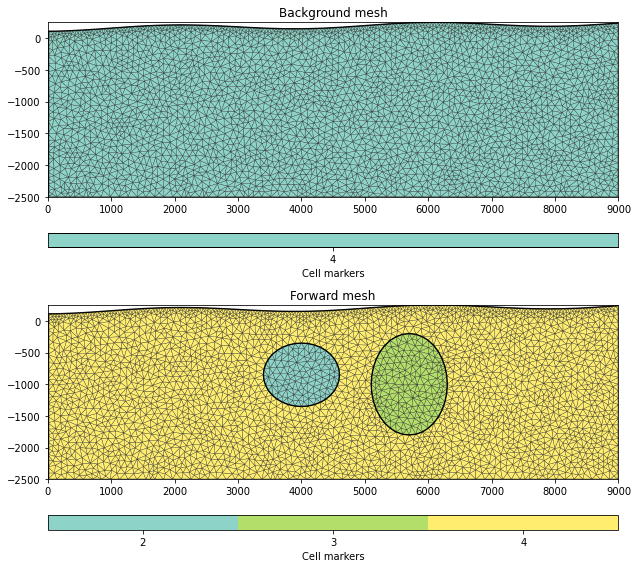

In [41]:
# Create elliptical anomalies
# Anomaly 1:
magma = mt.createCircle(pos=[4000.0, -850.], segments=36, radius=[600.0, 500.0], marker=2,
                        area=8000.0)
# Anomaly 2:
pluton = mt.createCircle(pos=[5700.0, -1000.], segments=36, radius=[600.0, 800.0], marker=3,
                        area=8000.0)
# Define a function to create land topography 
def surf(x):
    y =150 - 40 * np.cos(2 * np.pi * 1/4000 * x) +x*0.01
    return y

# We define the location of sources here so that we can give each one a node in the mesh
# shots every 50 m at the surface
shotsx = np.arange(0., 9050.,50.0)
shotsy = surf(shotsx)
# Receivers every 500 m at the surface
obsx = np.arange(500.0, 9000.0, 500.)
obsy = surf(obsx)

# Create topography
topo = [[x,surf(x)] for x in shotsx]
topo.append([9000,-2500])
topo.append([0,-2500])

# Create main polygon for the mesh with topography as top surface
main = mt.createPolygon(topo,area=8000,isClosed=True, marker=4)
plc = main
    
# Merge polygons into a single mesh for true model and background model
# The variable quality sets the quality of the mesh
# The variable area sets the maximum area of each cell in the mesh in m^2.
mesh_for = mt.createMesh(plc + magma + pluton, quality=32, area=8000)
# The background model doesn't include the elliptical anomalies
mesh_bg = mt.createMesh(plc, quality=32, area=8000)

# Plot meshes
fig, ax = plt.subplots(2,1,figsize=(10,8))
pg.show(mesh_bg,markers=True, showMesh=True,ax=ax[0])
pg.show(mesh_for,markers=True, showMesh=True,ax=ax[1])
ax[0].set_title("Background mesh")
ax[1].set_title("Forward mesh")
fig.tight_layout()

# Define velocity model
Here we add velocity information to the meshes.
We create a background velocity by "hanging" a 1d velocity model to the surface topography. The true model is built by adding the velocity anomalies and a random perturbation to the background model. The velocity information is stored in separate files from the mesh files.

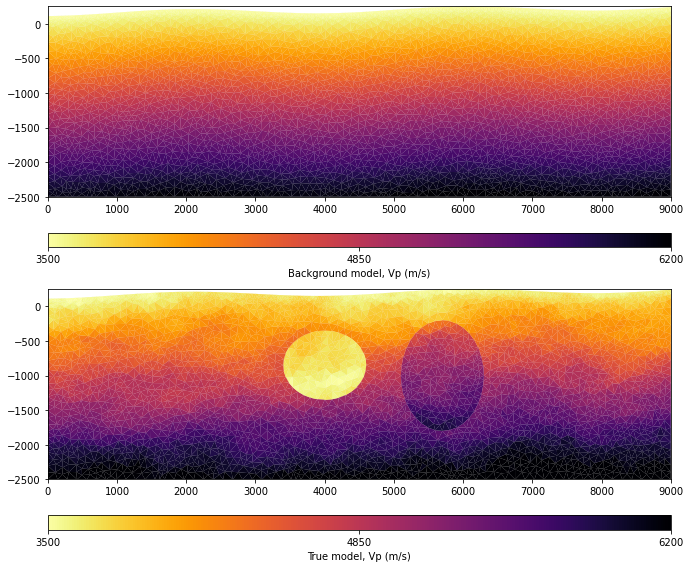

In [35]:
# Remove boundary markers
for boundary in mesh_for.boundaries():
    boundary.setMarker(0)
for boundary in mesh_bg.boundaries():
    boundary.setMarker(0)

# Initialise lists that will contain the velocity information
vel_for = []
vel_bg = []
# Define background velocity model
a = 3500  # Vp value at the surface in m/s
b = 1.0   # Vertical Vp gradient in (m/s)/m
# Create velocities "hanging" from topography
for node in mesh_bg.nodes():
    vel_bg.append(a+b*(abs(node.y()-surf(node.x()))))    
for node in mesh_for.nodes():
    vel_for.append(a+b*(abs(node.y()-surf(node.x()))))

# Add velocity info to mesh
vel_for = pg.meshtools.nodeDataToCellData(mesh_for,np.array(vel_for))
vel_bg = pg.meshtools.nodeDataToCellData(mesh_bg,np.array(vel_bg))

# Add anomalies to velocity model
c = 3600  # Vp value inside anomaly 1
d = 400   # Vp anomaly inside anomaly 2
for i,cell in enumerate(mesh_for.cells()):
    if cell.marker() == 2:
        vel_for[i] = c
    elif cell.marker() == 3:
        vel_for[i] = vel_for[i]+d

# Add random perturbations to true model
random = pg.utils.generateGeostatisticalModel(mesh_for, I=[1000, 500])
vel_for = vel_for+random*100     

# Plot background model and true model
fig, ax = plt.subplots(2,1,figsize=(10,8))
pg.show(mesh_bg, vel_bg, label="Vp (m/s)",ax=ax[0],cMap=pg.cmap('vel'), nLevs=3,cMin=3500,cMax=6200)
pg.show(mesh_for, vel_for, label="Vp (m/s)",ax=ax[1],cMap=pg.cmap('vel'), nLevs=3,cMin=3500,cMax=6200)
ax[0].set_title("Background model")
ax[1].set_title("True model")
fig.tight_layout()

# Experiment set up
Here we define the acquisition geometry of the experiment and define the variable that we need to simulate the ray propagation.

In [14]:
from itertools import product

# Define shot locations
shots = np.zeros((len(shotsx), 2)) 
shots[:, 0] = shotsx  # x
shots[:, 1] = shotsy

# Define receiver locations
obss = np.zeros((len(obsx), 2)) 
obss[:, 0] = obsx  # x
obss[:, 1] = obsy

# Create labels for the shots
shotsn = np.arange(len(shotsx))
# Find a label for each receiver that correspond to the shot at that position
obsn = []
for i in shotsn:
    if shotsx[i] in obsx:
        obsn.append(i)     

# Define source-receiver pairs 
rays = list(product(obsn,shotsn))

# Remove pairs were source and receiver are close to each other
# You can modify this to exclude short offsets or long offsets from your inversion
remove=[]
for i,r in enumerate(rays):
    if abs(r[0] - r[1]) < 2 :
        remove.append(r)        
for r in remove:
    rays.remove(r)
    
# Create empty data container
scheme = pg.DataContainer()        

# Add shots and receivers as "sensors". Pygimli doesn't distinguish
# between sources and receivers. They are all called "sensors".
for i in shotsn:
    scheme.createSensor((shotsx[i],shotsy[i]))

# Add measurements, i.e. read the source-receiver pairs defined above
rays = np.array(rays)
scheme.resize(len(rays))
scheme["s"] = rays[:, 0]
scheme["g"] = rays[:, 1]
scheme["valid"] = np.ones(len(rays))
scheme.registerSensorIndex("s")
scheme.registerSensorIndex("g")
print("Done")

Done


# Calculate traveltimes and draw raypaths
Here we calculate synthetic traveltimes for the true model. These will be our data for the following inversion.
The parameter "secnodes" can be increased to make the ray tracing more accurate.
The traveltimes are calculated by finding the path of minimum traveltime between each source and receiver pair. This means that we can only calculate the first arrival traveltimes. Later ariving phases may exist but cannot be calculated with this method.

In [15]:
# Initialise traveltime manager
vel_run = vel_for
mesh_run = mesh_for
tt = TravelTimeManager()
secnodes=5  # Number of secondary nodes

pg.tic()
syn = tt.simulate(mesh=mesh_run, scheme=scheme, slowness=1./vel_run,secNodes=secnodes,
                 noiseLevel=0.001, noiseAbs=1e-5, seed=1337, verbose=1,debug=True)
pg.toc("Raytracing with %d secondary nodes:" % secnodes)
print(syn)
Printed ("Done")

10/12/20 - 15:45:02 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Raytracing with 5 secondary nodes: Elapsed time is 10.75 seconds.
Data: Sensors: 181 data: 3026, nonzero entries: ['err', 'g', 's', 't', 'valid']


# Plotting the ray paths
Here we plot the paths of the rays calculated in the previous step. Notice how the rays "avoid" the low velocity anomaly. Think about why this is the case. Remember that we are calculating the first arrival traveltimes. What will be the consequences of the rays avoiding the low velocity anomaly on the ability of the inversion to recover the structure? How could we change the experiment geometry to sample deeper into the subsurface?

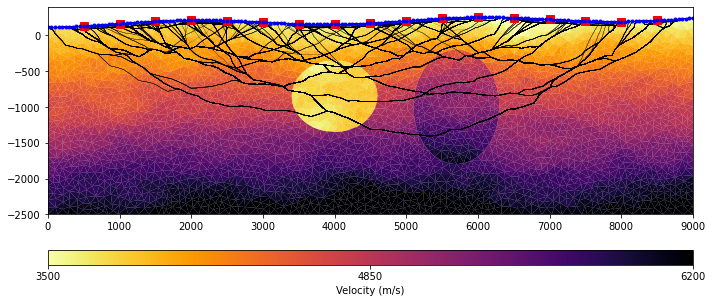

In [39]:
fig, ax = plt.subplots(figsize=(10, 7))
# Plot the velocity model
pg.show(mesh_run, vel_run, ax=ax, label="Velocity (m/s)", hold=True,
       logScale=False, cMap=pg.cmap('vel'), nLevs=3,cMin=3500,cMax=6200)

# Plot rays
tt.drawRayPaths(ax=ax, model=vel_run, color="k", lw=0.3, alpha=0.5)
ax.plot(obsx, obsy, "rs", ms=8)     # plot receivers as red squaress
ax.plot(shotsx, shotsy, "bo", ms=3) # plot shots as blue dots
ax.set_ylim(mesh_run.ymin(), 400)   # set y axis limits
fig.tight_layout()

# Ploting the traveltimes
Here we plot the synthetic traveltimes. Traveltimes for each receiver are oplotted in a different color. Can you spot the signature of the low velocity anomaly in the traveltime curves?

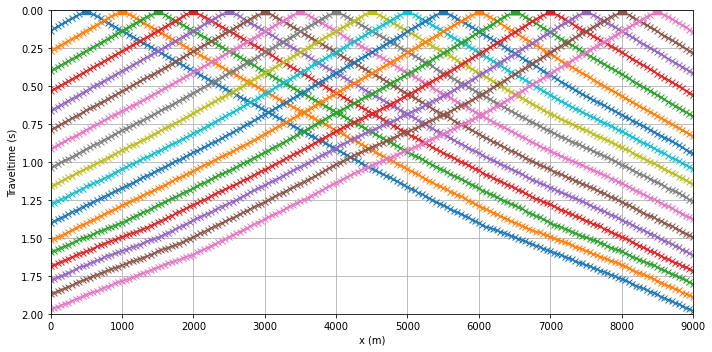

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylim(0, 2.0)
ax.set_xlim(0, 9000)
pg.physics.traveltime.drawFirstPicks(ax, syn)
fig.tight_layout()

# Inversion
Here we carry out an inversion of the syntehtic traveltimes calculated above. The synthetic traveltimes represent our data. Our starting model is the background velocity model. The goal is to recover the anomalies of the true model.
The inversion is an iterative process. At each iteration we need to trace the rays and calculate the traveltimes so that we can compare them to the data and calculate the traveltime residuals. **This may take a few minutes.**

How do we chose when to stop the inversion?
An iterative inversion presents a dilemma: if at each iteration we get closer to the "true model", how do we choose when to stop? Here we use three separate criteria:
- When the $\chi^2 $ is 1. The $\chi^2$ is a measure of how closely the predicted traveltimes fit the data. A $\chi^2$ of 1 means that we can fit the data to within the given uncertainty.
- When the inversion converges. If the improvement at each step is very small we can stop the inversion. We can set this with the parameter dPhi. This represents the minimum improvement in the data norm (the total misfit). If dPhi goes below 1% we stop the inversion.
- When we run out of time. If the inversion is not well tuned it may not converge. In this case we stop the inversion after 20 iterations.


In [18]:
#Inversion
lam = 500.  # Regularization parameter. This parameter is crucial for tuning the inversion.
# We will look into it in detail in the next exercise.
tt.invert(syn, mesh=mesh_bg, startModel=1./vel_bg, secNodes=5,zWeight=0.5, 
          verbose=1, maxiter=20, lam=lam, dPhi=1) 

print("chi^2 = %.2f" % tt.inv.chi2())  # Look at the data fit

10/12/20 - 15:49:13 - pyGIMLi - INFO - Found 1 regions.
10/12/20 - 15:49:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/12/20 - 15:49:13 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
10/12/20 - 15:49:13 - pyGIMLi - INFO - Startmodel set from given array. 5420 [0.0002806728764821717,...,0.00016755937742097502]
10/12/20 - 15:49:13 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.TravelTimeManager.TravelTimeDijkstraModelling object at 0x7f583049e2d0>
Data transformation: <pygimli.core._pygimli_.RTrans object at 0x7f583048e490>
Model transformation (cumulative):
	 0 <pygimli.core._pygimli_.RTransLogLU object at 0x7f582e83e260>
min/max (data): 0.026/1.98
min/max (error): 0.1%/0.14%
min/max (start model): 1.6e-04/2.8e-04
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 42.76 (dPhi = 7.77%) lam: 500.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 33.82 (dPhi = 20.9%) lam: 500.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 23.58 (dPhi = 30.22%) lam: 500.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 20.28 (dPhi = 13.95%) lam: 500.0

# Plotting the results
Here we plot a comparison of the true model and the recovered model. How well did we do? How could we do better? 

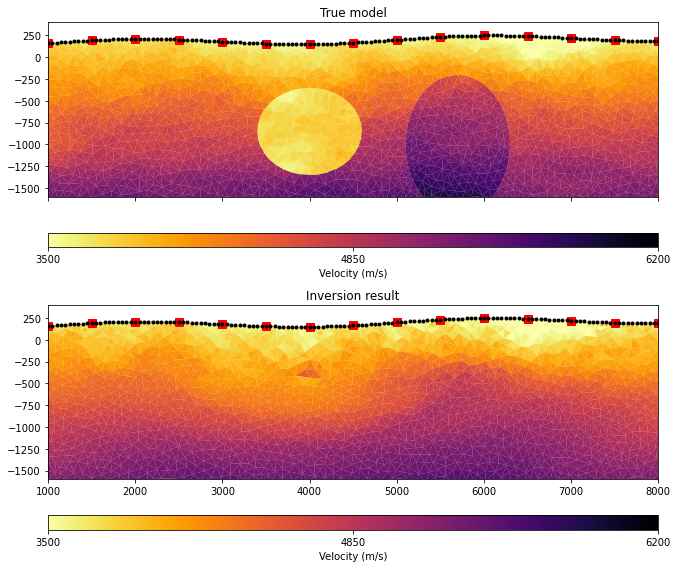

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True, sharey=True)
ax1.set_title("True model")
ax2.set_title("Inversion result")

pg.show(mesh_for, vel_for, ax=ax1, showMesh=False,
        label=pg.unit('vel'), cMap=pg.cmap('vel'), nLevs=3,cMin=3500,cMax=6200)

tt.showResult(ax=ax2, logScale=False, showMesh=False, nLevs=3,cMin=3500,cMax=6200)

#tt.drawRayPaths(ax=ax2, color="0.8", alpha=0.3)
for ax in (ax1, ax2):
    ax.plot(obsx, obsy, "rs", ms=8)
    ax.plot(shotsx, shotsy, "ko", ms=3)
    ax.set_ylim(-1600,400)
    ax.set_xlim(1000,8000)
fig.tight_layout()